In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
import os
import shutil
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import kagglehub
from skimage.filters import gaussian
from skimage.util import random_noise
from PIL import Image
import matplotlib.image as mpimg
import multiprocessing as mp
import threading as th
import cv2

import tensorflow as tf
import tensorflow.image as tfi
import keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from glob import glob
import random
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import UpSampling2D, concatenate, Add, Multiply, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from IPython.display import clear_output


In [19]:
# accsess the data files and dir
path     = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [20]:
cancer_rays_dir = os.listdir("/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1")
cancer_rays_dir_str ="/root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1"

In [21]:
print(cancer_rays_dir)
print(len(cancer_rays_dir))

['10303', '10259', '13020', '9078', '9126', '15512', '8917', '16534', '12934', '12882', '14305', '10301', '16568', '15840', '14191', '13693', '9266', '10256', '9260', '9036', '12929', '12949', '13024', '16555', '12822', '10258', '12242', '12907', '14192', '16553', '10299', '10307', '15839', '14155', '12241', '12751', '14082', '15473', '13616', '13666', '12752', '12897', '10264', '10305', '9320', '10302', '8984', '8957', '12871', '12911', '9176', '15514', '9345', '12906', '16551', 'IDC_regular_ps50_idx5', '14079', '10304', '9250', '9262', '9077', '14304', '10295', '9382', '9325', '9267', '10273', '13591', '12869', '12896', '13019', '12935', '9290', '13688', '15472', '14211', '10285', '12817', '8863', '10253', '13916', '16532', '13617', '15903', '10286', '9323', '15632', '13692', '14321', '9258', '14306', '12811', '13025', '10290', '15510', '16166', '15902', '13404', '16896', '10300', '10254', '12893', '10291', '16569', '12948', '12898', '9076', '16550', '12930', '13459', '9178', '14188'

In [7]:
# Access the data files and dir
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")
print("Path to dataset files:", path)

# Get the list of patient directories
cancer_rays_dir = os.listdir(path)
# Corrected: Using the 'path' variable, which contains the correct dataset path

# Create the destination directory if it doesn't exist
all_rays_dir = "all_rays_dir"
os.makedirs(all_rays_dir, exist_ok=True)

# Iterate through patient directories
for patient in cancer_rays_dir:
    # Construct correct paths using os.path.join
    path_0 = os.path.join(path, patient, '0')
    path_1 = os.path.join(path, patient, '1')

    # Check if the directories exist before listing their contents
    if os.path.exists(path_0):
        file_list_0 = os.listdir(path_0)
        for fname in file_list_0:
            src = os.path.join(path_0, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)

    if os.path.exists(path_1):
        file_list_1 = os.listdir(path_1)
        for fname in file_list_1:
            src = os.path.join(path_1, fname)
            dst = os.path.join(all_rays_dir, fname)
            shutil.copyfile(src, dst)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1


In [8]:
all_rays_dir_lst = os.listdir('./all_rays_dir')
len(all_rays_dir_lst)

277524

In [9]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

image_id
0    9037_idx5_x2151_y201_class1.png
1   12749_idx5_x1601_y951_class0.png
2  16165_idx5_x2401_y1801_class1.png
3   9181_idx5_x1051_y1151_class0.png
4     9266_idx5_x901_y301_class0.png

In [10]:
#Based on the addition that I added earlier in the path, I divided the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0    9037_idx5_x2151_y201_class1.png      1
1   12749_idx5_x1601_y951_class0.png      0
2  16165_idx5_x2401_y1801_class1.png      1
3   9181_idx5_x1051_y1151_class0.png      0
4     9266_idx5_x901_y301_class0.png      0
5    8956_idx5_x2301_y251_class0.png      0
6   12880_idx5_x651_y1251_class1.png      1
7     9077_idx5_x501_y951_class0.png      0
8  15472_idx5_x2951_y1301_class0.png      0
9   15512_idx5_x501_y1301_class1.png      1

In [11]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]

    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0    9037_idx5_x2151_y201_class1.png      1       9037
1   12749_idx5_x1601_y951_class0.png      0      12749
2  16165_idx5_x2401_y1801_class1.png      1      16165
3   9181_idx5_x1051_y1151_class0.png      0       9181
4     9266_idx5_x901_y301_class0.png      0       9266

In [12]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

# **Exploratory Data Analysis**

**Healthy Patches**

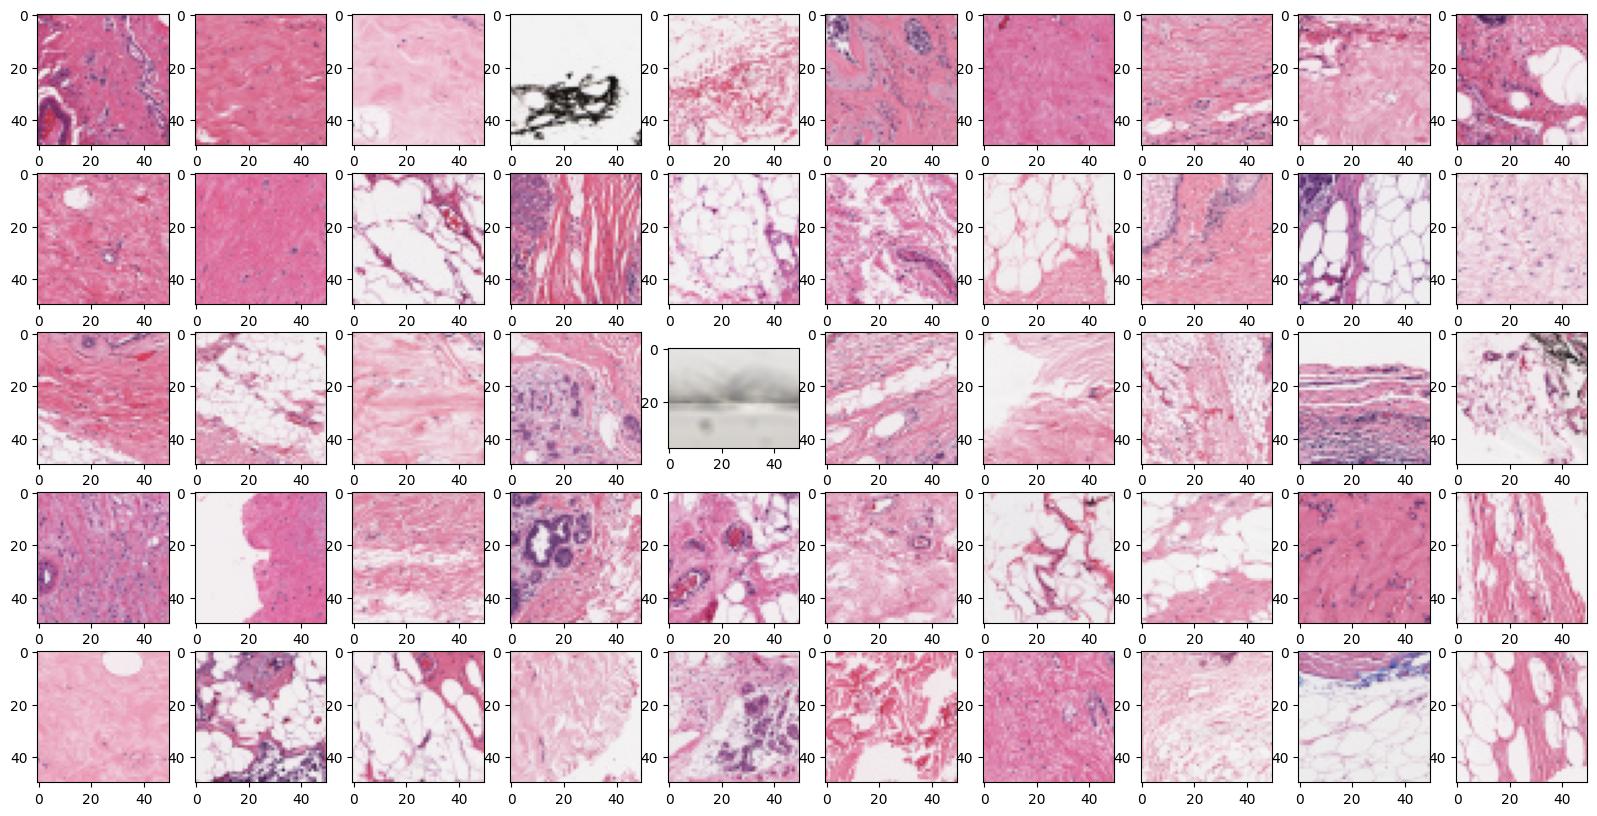

In [13]:
data.target = data.target.astype(int)
fig, ax = plt.subplots(5,10,figsize=(20,10))
pos_selection = np.random.choice(data[data.target ==1].index, size=50, replace=False,)
neg_selection = np.random.choice(data[data.target ==0].index, size=50, replace=False,)
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Most of the mammograms are light pink, but there are some dark ones too

**Cancer patches**

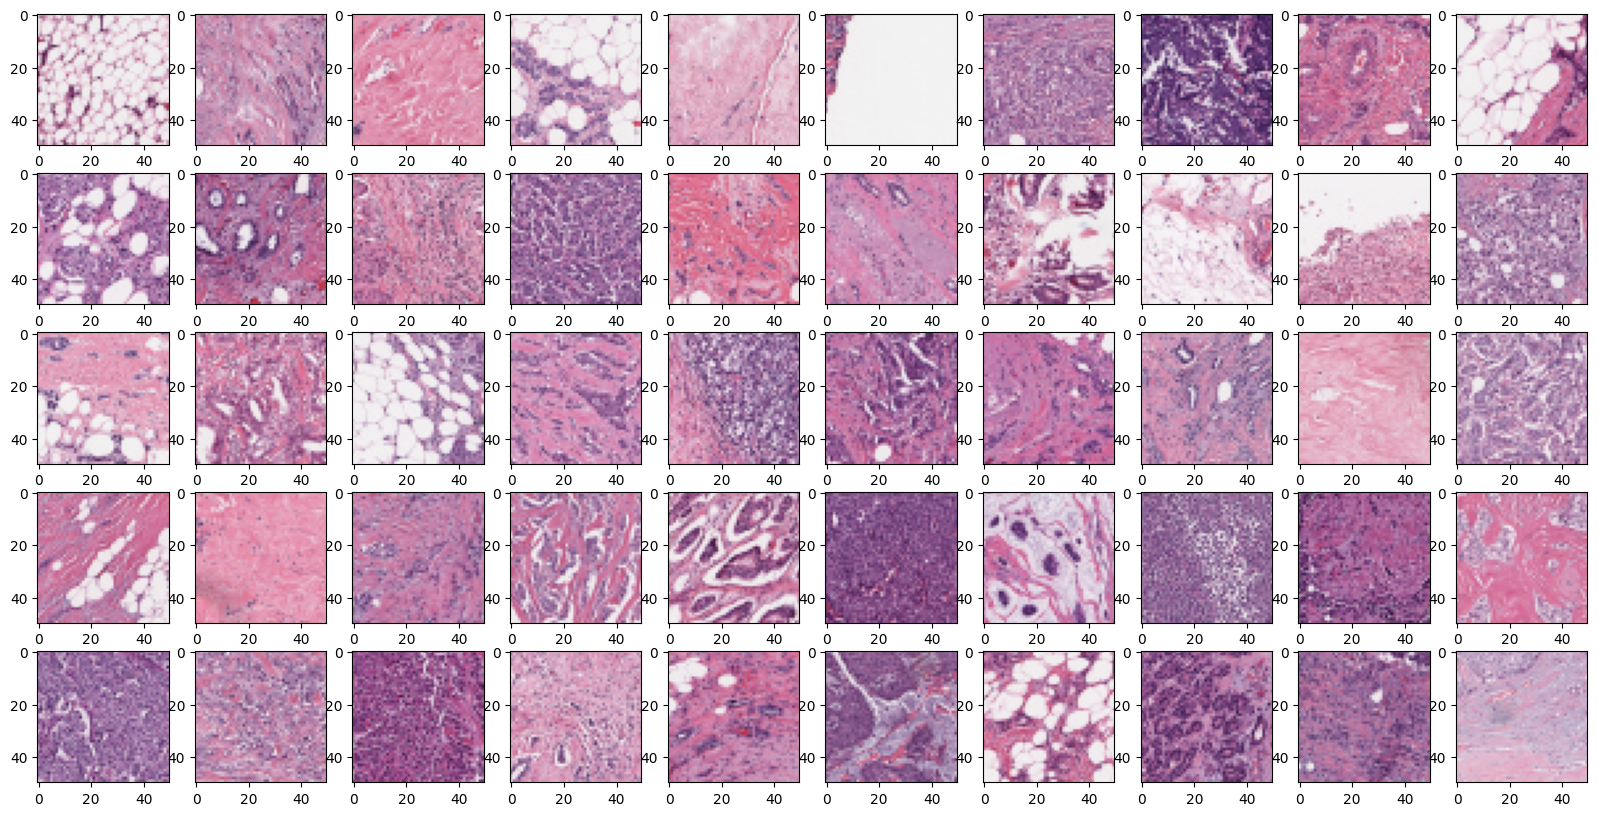

In [14]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)



*   Patches with cancer look more violet and crowded than healthy ones.
*   In fact, we could not determine the actual difference between the two types with the naked eye, but I think that the model is able to detect hidden patterns in these images that enable us to determine the state of each image.

Let's ask some questions that will help us get to know more our data:

*   Do all patients have the same number of mammograms?
*   What is the percentage of cancer (IDC) that each mammogram shows?
*   How many healthy and cancered mammograms are in the data?


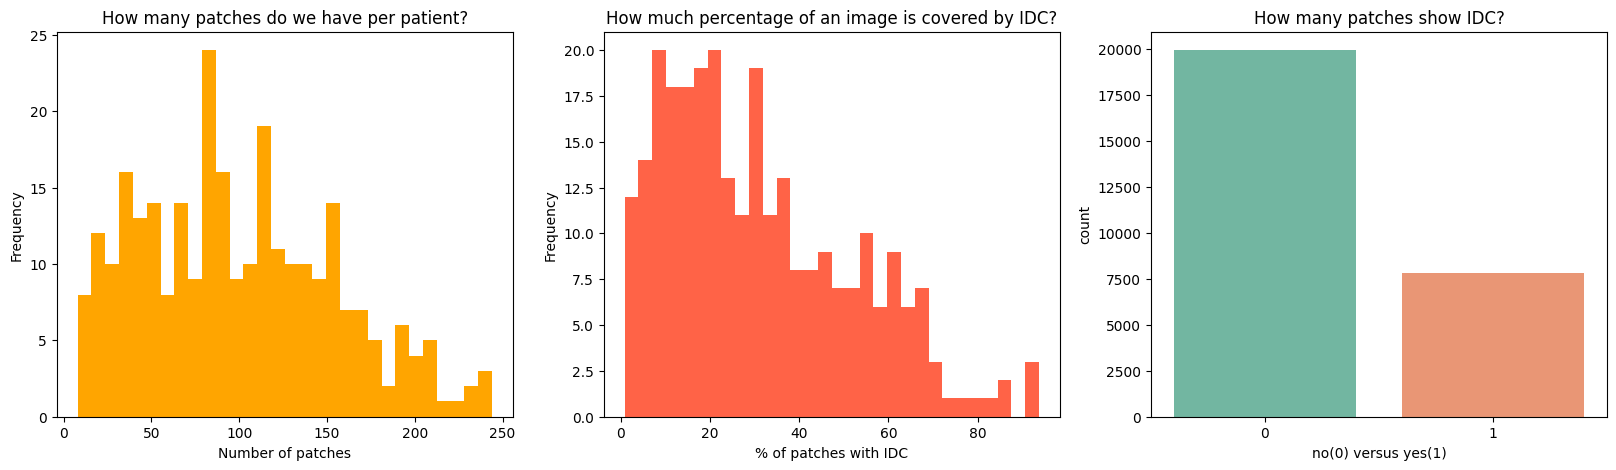

In [16]:
# Sample a fraction of the data
sample_fraction = 0.1
sampled_data = data.sample(frac=sample_fraction, random_state=42)  # Set random_state for reproducibility

# Pre-compute aggregations
patient_patch_counts = sampled_data.groupby("patient_id").size()
cancer_perc = sampled_data.groupby("patient_id").target.value_counts() / patient_patch_counts
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Number of patches per patient
ax[0].hist(patient_patch_counts, bins=30, color="Orange")
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plot 2: Percentage of image covered by IDC
ax[1].hist(cancer_perc.loc[:, 1] * 100, bins=30, color="Tomato")
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Plot 3: Number of patches showing IDC
sns.countplot(x='target', data=sampled_data, palette="Set2", ax=ax[2])
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?")

plt.show()

* The number of image patches per patient varies a lot
* Most of the photos have a percentage that is not large, but there are other photos that have a percentage of up to 80%
* The smaller number of mammograms had cancer

In [31]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = os.path.join(cancer_rays_dir_str, patient_id, cancer_id) #use os.path.join to avoid manually adding '/'
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x    y  target                                               path
0  2151  801       0  /root/.cache/kagglehub/datasets/paultimothymoo...
1   701  351       0  /root/.cache/kagglehub/datasets/paultimothymoo...
2  1901  501       0  /root/.cache/kagglehub/datasets/paultimothymoo...
3  2251  701       0  /root/.cache/kagglehub/datasets/paultimothymoo...
4  2051  901       0  /root/.cache/kagglehub/datasets/paultimothymoo...

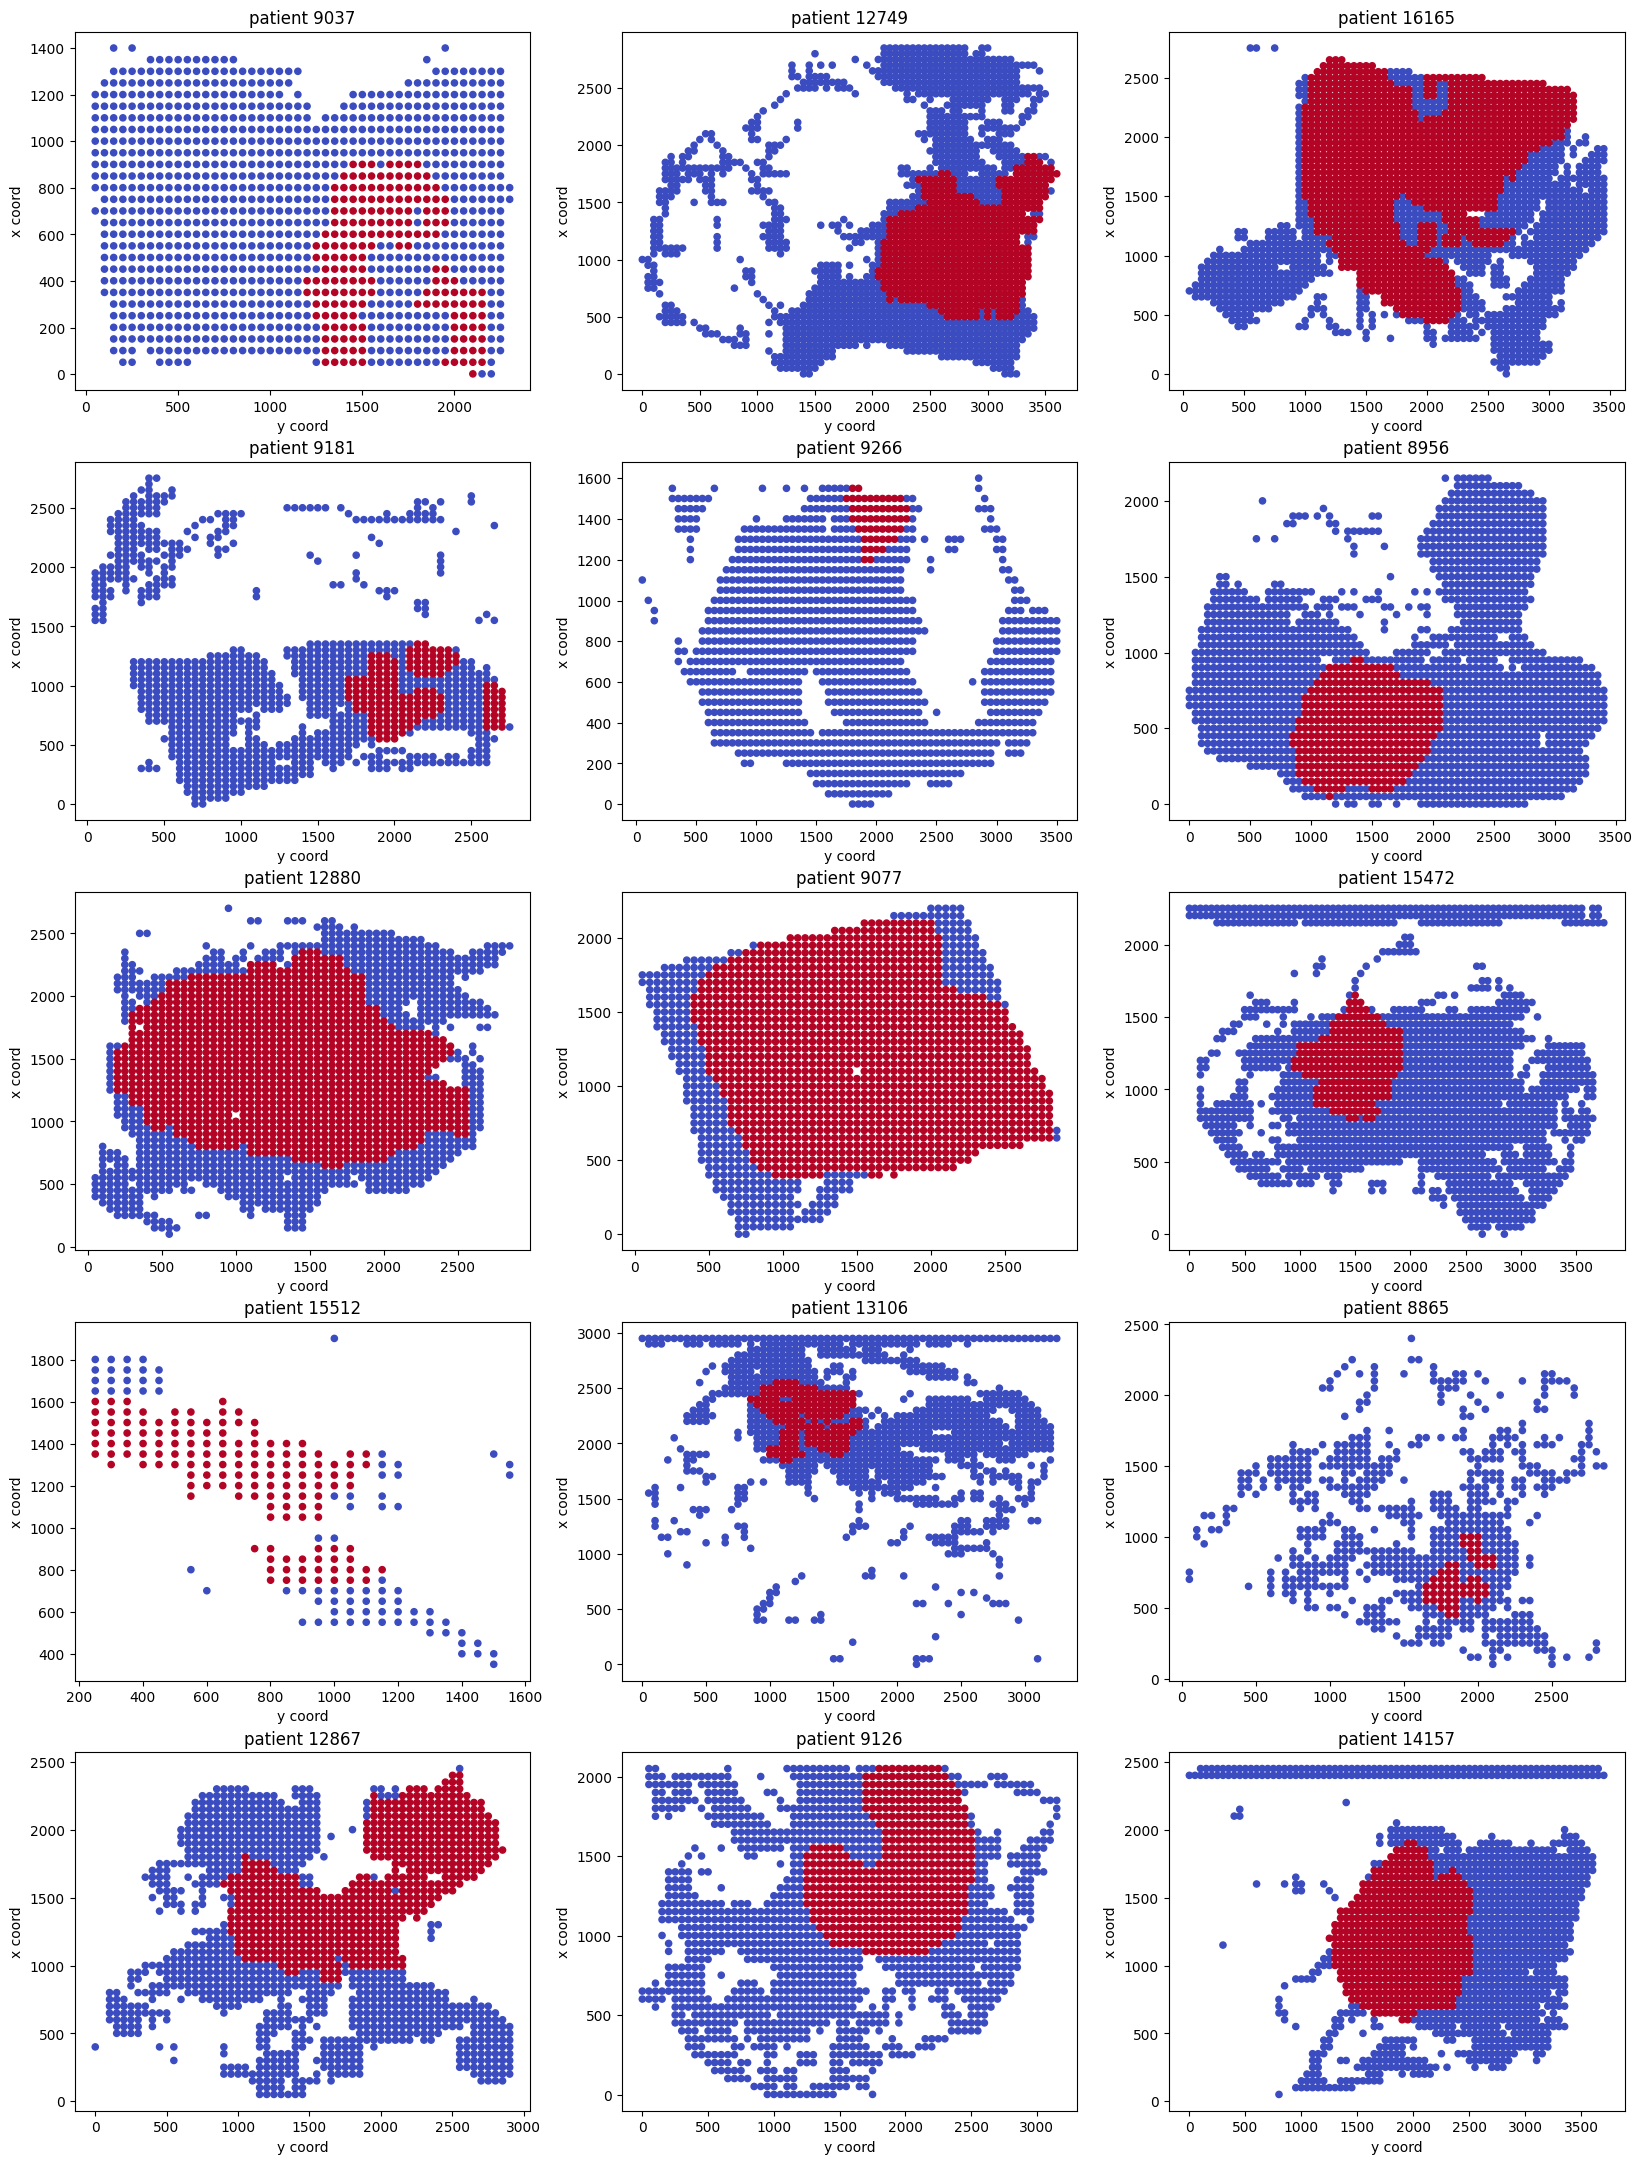

In [32]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)

        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

# **Image Processing**

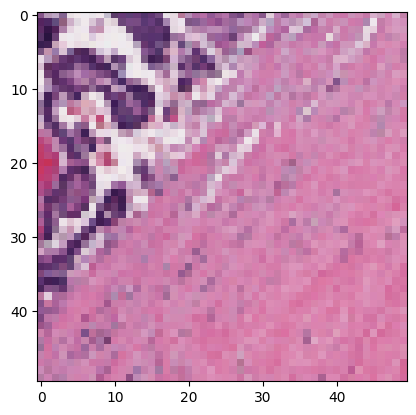

In [34]:
data.target = data.target.astype(int)
random_image_path = np.random.choice(data[data.target ==0].index, size=1, replace=False,)
path =os.path.join(all_rays_dir,data.loc[random_image_path[0], 'image_id'])
image = mpimg.imread(path)
plt.imshow(image)

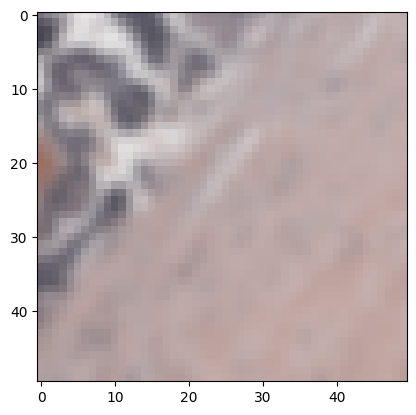

In [35]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image)

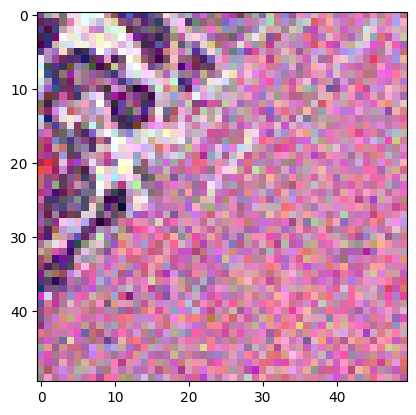

In [36]:
noise_image = random_noise(image)
plt.imshow(noise_image)

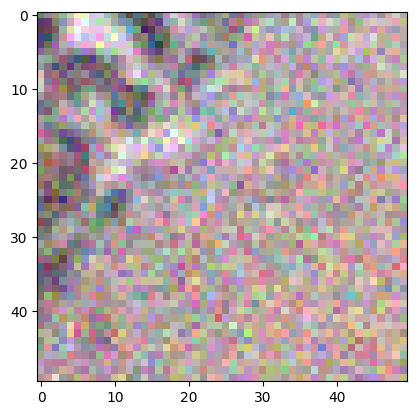

In [37]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image)

Processing using (random_noise) function

In [38]:
os.mkdir('image_processing') # create a new file to process the data in
os.mkdir('image_processing/noise_images')

In [46]:
def process_image(normal_image):
    path = os.path.join(all_rays_dir, normal_image)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
    noise_image = random_noise(img)
    fname = normal_image
    new_path = os.path.join('image_processing/noise_images', fname)
    cv2.imwrite(new_path, noise_image)  # Save the image

In [48]:
os.mkdir( 'image_processing/processd_data_train')
os.mkdir( 'image_processing/processd_data_test')
os.mkdir( 'image_processing/processd_data_train/zeros')
os.mkdir( 'image_processing/processd_data_train/ones')
os.mkdir( 'image_processing/processd_data_test/zeros')
os.mkdir( 'image_processing/processd_data_test/ones')

In [50]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0    9037_idx5_x2151_y201_class1.png
1   12749_idx5_x1601_y951_class0.png
2  16165_idx5_x2401_y1801_class1.png
3   9181_idx5_x1051_y1151_class0.png
4     9266_idx5_x901_y301_class0.png

In [51]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0    9037_idx5_x2151_y201_class1.png      1
1   12749_idx5_x1601_y951_class0.png      0
2  16165_idx5_x2401_y1801_class1.png      1
3   9181_idx5_x1051_y1151_class0.png      0
4     9266_idx5_x901_y301_class0.png      0
5    8956_idx5_x2301_y251_class0.png      0
6   12880_idx5_x651_y1251_class1.png      1
7     9077_idx5_x501_y951_class0.png      0
8  15472_idx5_x2951_y1301_class0.png      0
9   15512_idx5_x501_y1301_class1.png      1

In [52]:
processd_data['target'].value_counts()

target
0    182852
1     72465
Name: count, dtype: int64

In [53]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [54]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)

In [55]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [56]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

164567
65218
18285
7247


* The processed images and the noraml are tested on the same model to see which the best in the accuracy
* A small sample is taken for testing (20,000) images

*The Processed Images*

In [57]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0    9037_idx5_x2151_y201_class1.png      1
1   12749_idx5_x1601_y951_class0.png      0
2  16165_idx5_x2401_y1801_class1.png      1
3   9181_idx5_x1051_y1151_class0.png      0
4     9266_idx5_x901_y301_class0.png      0
5    8956_idx5_x2301_y251_class0.png      0
6   12880_idx5_x651_y1251_class1.png      1
7     9077_idx5_x501_y951_class0.png      0
8  15472_idx5_x2951_y1301_class0.png      0
9   15512_idx5_x501_y1301_class1.png      1

In [58]:
os.mkdir( 'image_processing/model_tst')
os.mkdir( 'image_processing/model_tst/trainig')
os.mkdir( 'image_processing/model_tst/testing')
os.mkdir( 'image_processing/model_tst/trainig/zeros')
os.mkdir( 'image_processing/model_tst/trainig/ones')
os.mkdir( 'image_processing/model_tst/testing/zeros')
os.mkdir( 'image_processing/model_tst/testing/ones')

In [59]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)

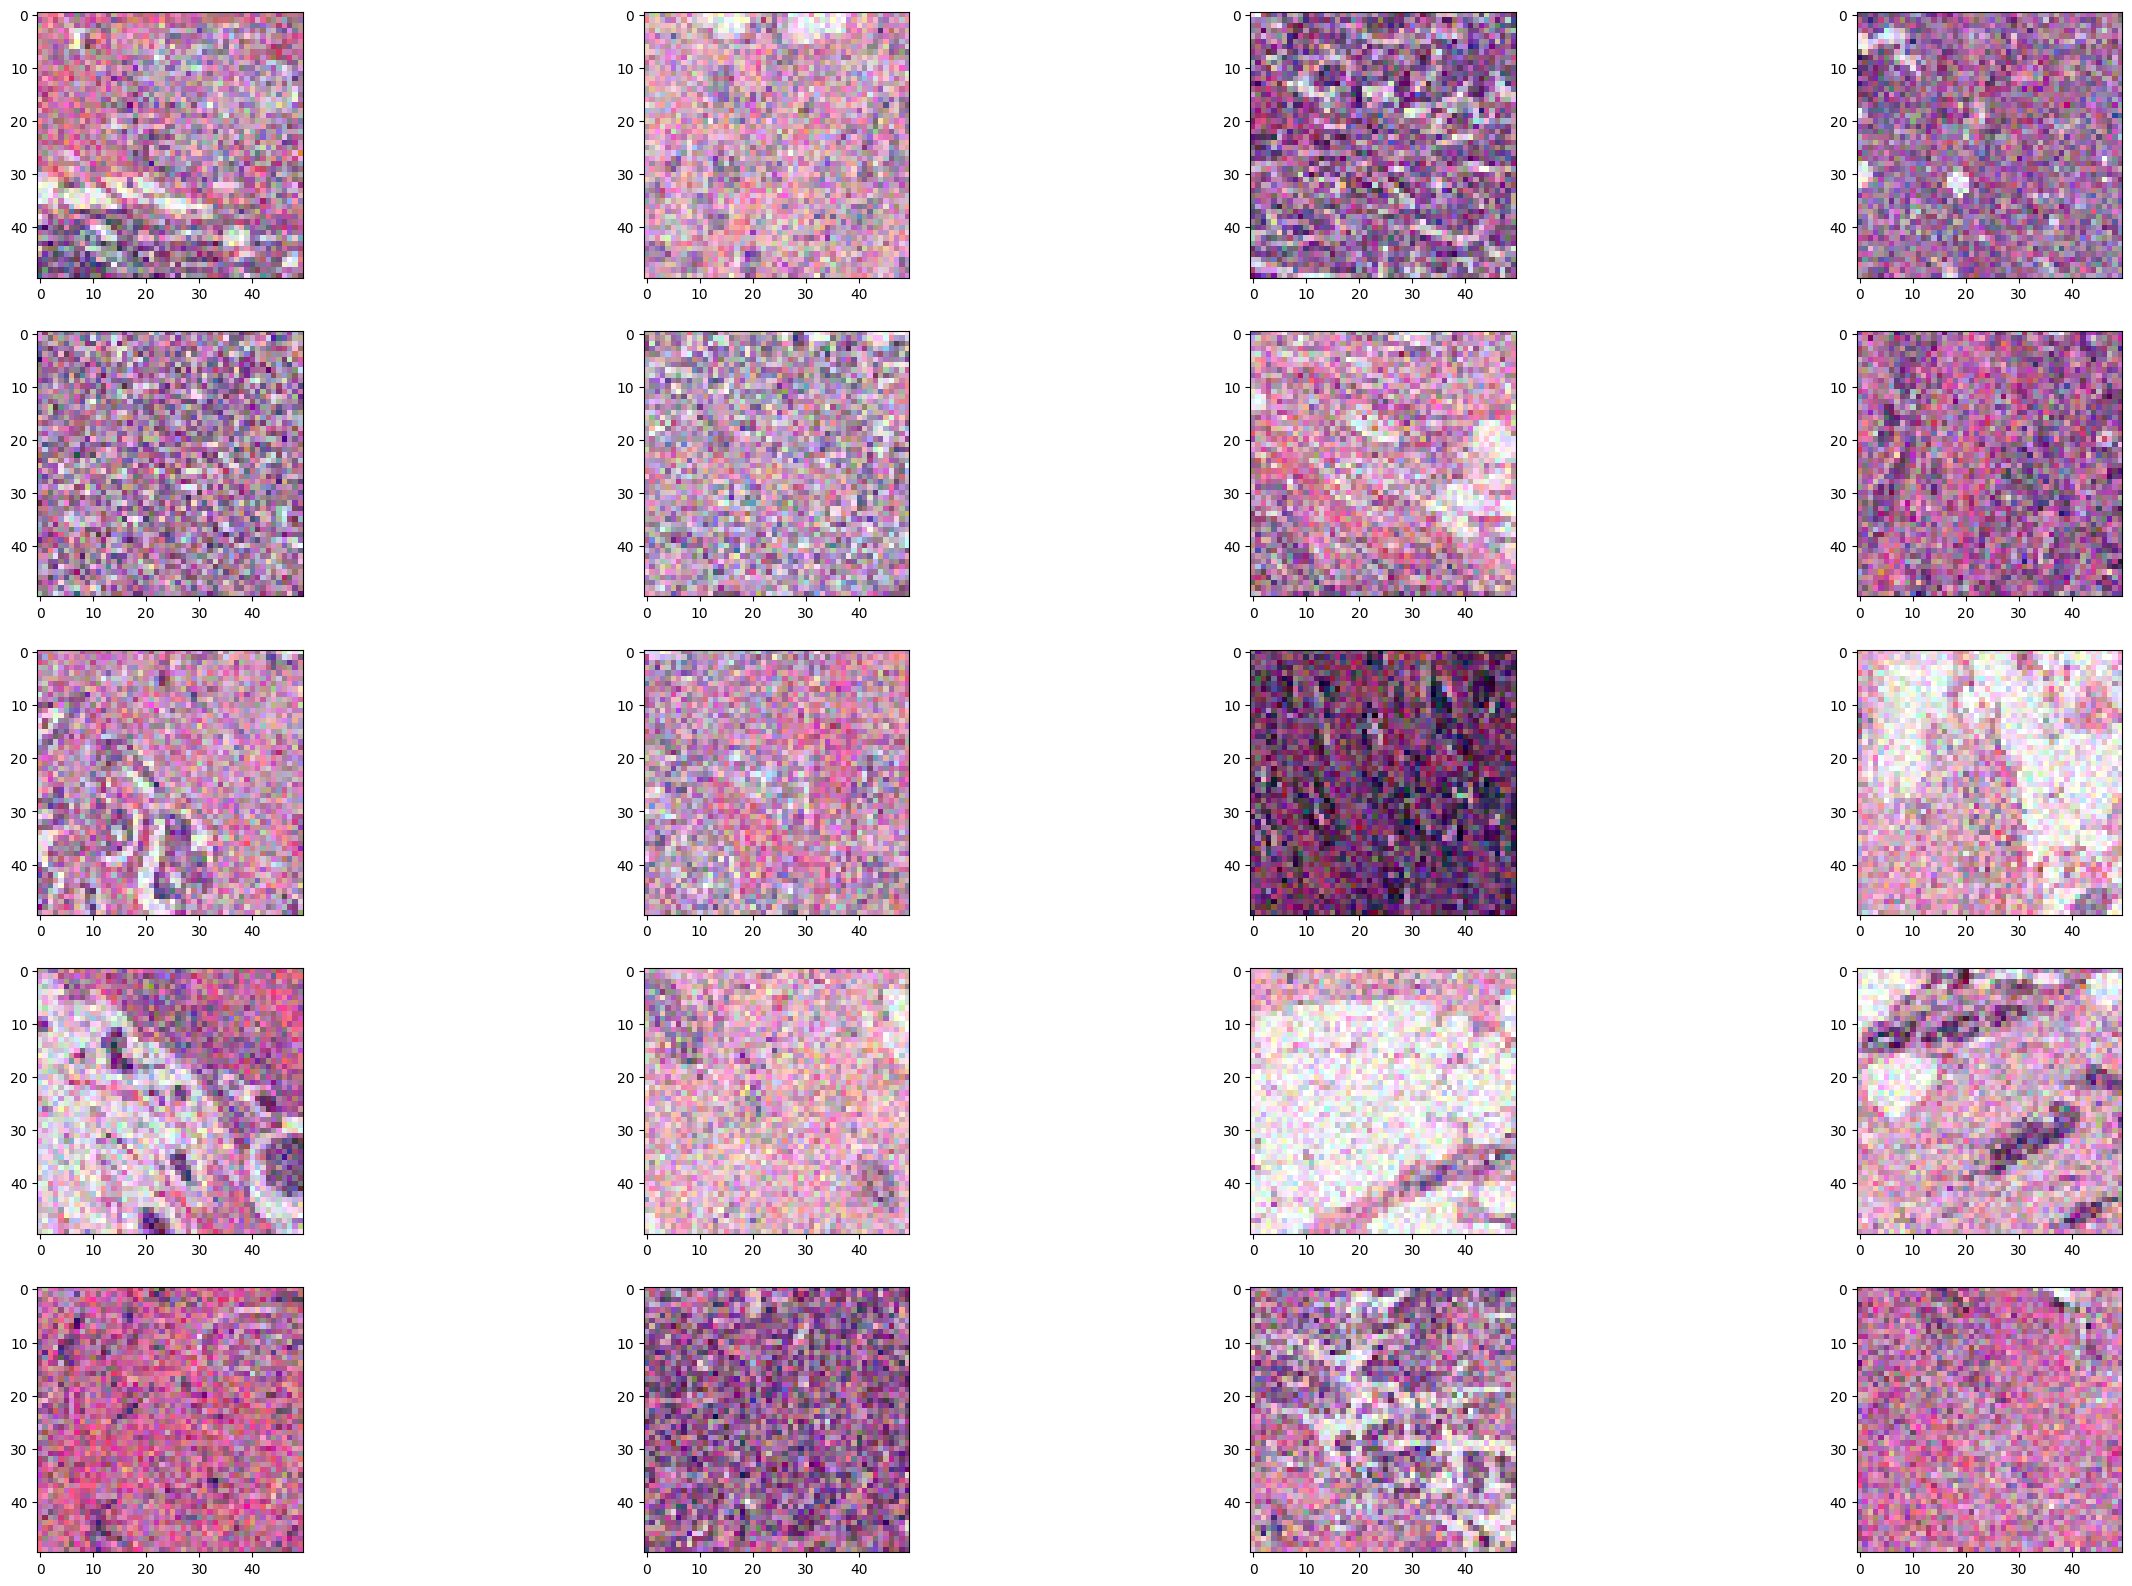

In [61]:
processd_data.target = processd_data.target.astype(int)
fig, ax = plt.subplots(5,4,figsize=(30,20))
pos_selection = np.random.choice(processd_data[processd_data.target==1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target==0].index.values, size=20, replace=False)
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Here are pictures of some of the processed carcinogenic images

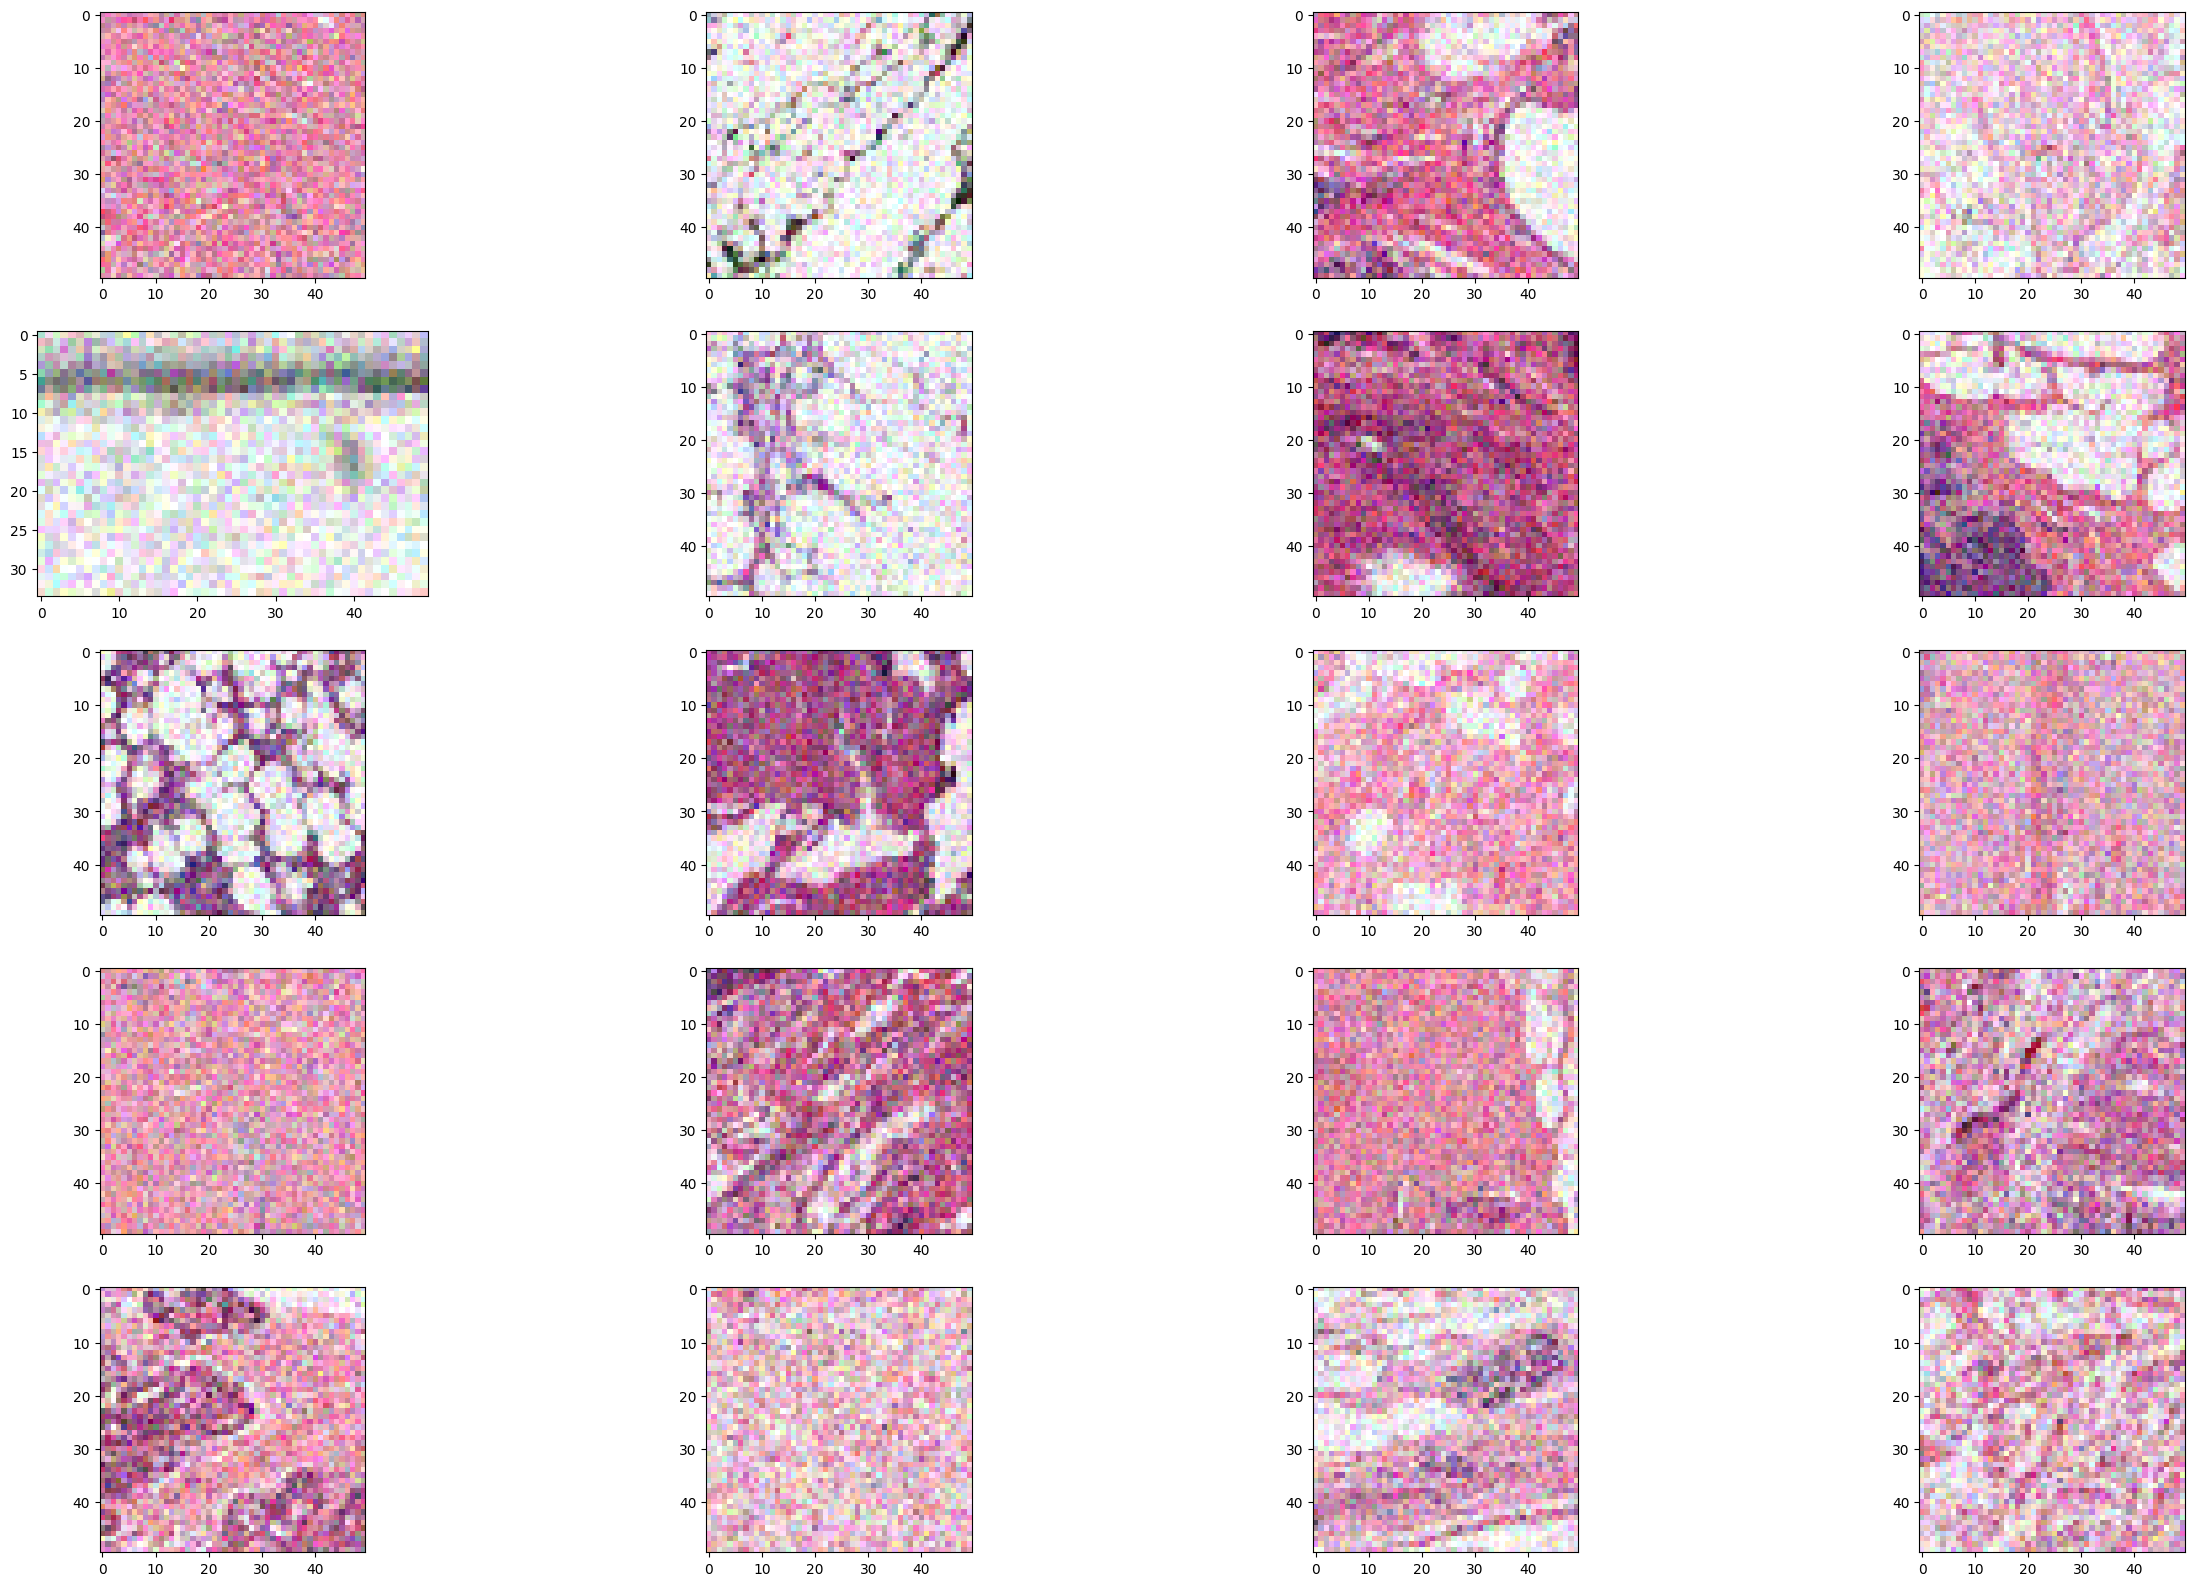

In [62]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Here are pictures of some of the normal images that have been processed

In [63]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [64]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [66]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_processd,validation_data=test_generation_processd,epochs=60, verbose=1,callbacks=[early_stop])

Epoch 1/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 111s 60ms/step - accuracy: 0.7085 - loss: 0.5975 - val_accuracy: 0.7840 - val_loss: 0.4977
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 108s 60ms/step - accuracy: 0.7686 - loss: 0.4998 - val_accuracy: 0.7995 - val_loss: 0.4653
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 111s 62ms/step - accuracy: 0.7777 - loss: 0.4812 - val_accuracy: 0.7665 - val_loss: 0.5139
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 105s 58ms/step - accuracy: 0.7955 - loss: 0.4612 - val_accuracy: 0.8025 - val_loss: 0.4564
Epoch 5/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 141s 58ms/step - accuracy: 0.7994 - loss: 0.4462 - val_accuracy: 0.7615 - val_loss: 0.4872
Epoch 6/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 148s 61ms/step - accuracy: 0.7974 - loss: 0.4364 - val_accuracy: 0.8060 - val_loss: 0.4721


*The Normal Images*

In [67]:
os.mkdir( 'image_processing/normal')
os.mkdir( 'image_processing/normal/model_tst')
os.mkdir( 'image_processing/normal/model_tst/trainig')
os.mkdir( 'image_processing/normal/model_tst/testing')
os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [68]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
for image in sts_train:
    fname  = image
    target = test_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
    shutil.copyfile(src, dst)
for image in tst_test:
    fname  = image
    target = test_data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
    shutil.copyfile(src, dst)

In [69]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [70]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [72]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model_im_processd.fit(train_generation_normal,validation_data=test_generation_normal,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 115s 64ms/step - accuracy: 0.8005 - loss: 0.4518 - val_accuracy: 0.8225 - val_loss: 0.4087
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 137s 61ms/step - accuracy: 0.8079 - loss: 0.4317 - val_accuracy: 0.8170 - val_loss: 0.4415
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 150s 65ms/step - accuracy: 0.8175 - loss: 0.4112 - val_accuracy: 0.7845 - val_loss: 0.4857


***Conclusion:*** Normal images are the best in modeling

# **Modeling**

**Data Splitting and Generation**

In [73]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0    9037_idx5_x2151_y201_class1.png      1
1   12749_idx5_x1601_y951_class0.png      0
2  16165_idx5_x2401_y1801_class1.png      1
3   9181_idx5_x1051_y1151_class0.png      0
4     9266_idx5_x901_y301_class0.png      0

In [74]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [75]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [76]:
os.mkdir( 'train_dir')
os.mkdir('test_dir')

In [77]:
os.mkdir( 'train_dir/zeros')
os.mkdir( 'train_dir/ones')

os.mkdir( 'test_dir/zeros')
os.mkdir( 'test_dir/ones')

In [78]:
train = data_train.image_id
test  = data_test.image_id

In [79]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']

    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [80]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)

In [81]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [82]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [83]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')

Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


**Model Design**

In [84]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [85]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2592)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         663,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
my_model.fit(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 1124s 45ms/step - accuracy: 0.8064 - loss: 0.4397 - val_accuracy: 0.7741 - val_loss: 0.4986
Epoch 2/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 1082s 43ms/step - accuracy: 0.8369 - loss: 0.3856 - val_accuracy: 0.8432 - val_loss: 0.3758
Epoch 3/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 1146s 45ms/step - accuracy: 0.8423 - loss: 0.3738 - val_accuracy: 0.8429 - val_loss: 0.3737
Epoch 4/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 1107s 43ms/step - accuracy: 0.8444 - loss: 0.3690 - val_accuracy: 0.8318 - val_loss: 0.3937
Epoch 5/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 1150s 45ms/step - accuracy: 0.8370 - loss: 0.3891 - val_accuracy: 0.8350 - val_loss: 0.3930


# **Outcomes**

In [87]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

accuracy      loss  val_accuracy  val_loss
0  0.822073  0.414566      0.774078  0.498596
1  0.838332  0.382239      0.843152  0.375776
2  0.842504  0.373627      0.842864  0.373686
3  0.841371  0.375325      0.831838  0.393677
4  0.834953  0.390944      0.835045  0.392981

<Axes: >

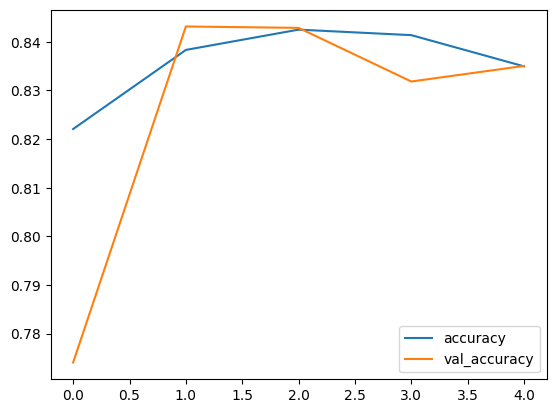

In [88]:
losse[['accuracy','val_accuracy']].plot()

<Axes: >

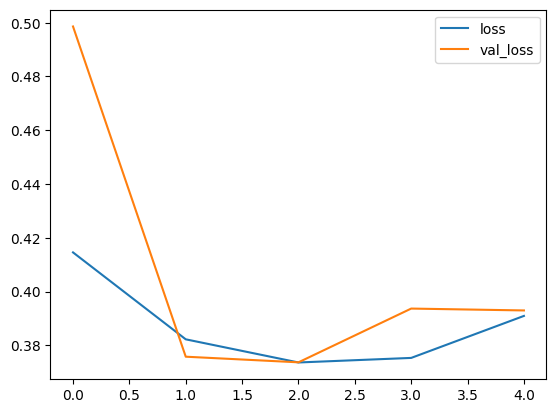

In [89]:
losse[['loss','val_loss']].plot()

In [91]:
val_loss, val_acc = \
my_model.evaluate(test_generation)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

2776/2776 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.8345 - loss: 0.3948
val_loss: 0.3929803669452667
val_acc: 0.8350448608398438


Model Results:
* After several attempts, made a good model design
* Model have a good acc = 84%
* Over fitting is so small

**Save & Load Model**

In [92]:
model_json = my_model.to_json()

In [94]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [96]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk
